# Exploration of airbnb and flat prices evolution in Madrid over last years

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def nice_line_plot(y_min, y_max, y_labels, x_categories, x_cat_1, districts, color_legend, legend_y_pos, 
                   data, title, link_data_source, link_source_hight):
    # Example obtained from blog post: 
    # http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
    
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(color_legend)):    
        r, g, b = color_legend[i]    
        color_legend[i] = (r / 255., g / 255., b / 255.)
           
    plt.figure(figsize=(15, 13)) 
    
    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    # Limit the range of the plot to only where the data is.    
    # Avoid unnecessary whitespace.    
    plt.ylim(y_min, y_max)    
    plt.xlim(x_categories[0], x_categories[-1]) 
    
    # Make sure your axis ticks are large enough to be easily read.    
    # You don't want your viewers squinting to read your plot.    
    plt.yticks(y_labels, y_labels, fontsize=8)    
    plt.xticks(fontsize=8)
    
    # Provide tick lines across the plot to help your viewers trace along    
    # the axis ticks. Make sure that the lines are light and small so they    
    # don't obscure the primary data lines.    
    for y in y_labels:    
        plt.plot(x_categories, [y] * len(x_categories), "--", lw=0.5, color="black", alpha=0.3)
        
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
  
    for rank, column in enumerate(districts):    
        # Plot each line separately with its own color, using the Tableau 20    
        # color set in order.    
        plt.plot(data.index.tolist(),    
                data[column].values,    
                lw=2.5, color=color_legend[rank])    
  
        plt.text(x_cat_1, legend_y_pos[rank], column, fontsize=10, color=color_legend[rank]) 

    plt.xlabel("Date")
    plt.title(title)      
    plt.text(x_categories[0], y_min-link_source_hight, "Data source: "+link_data_source+    
           "\nAuthor: Celsa Diaz", fontsize=8)    
    
    #plt.savefig(title+".png", bbox_inches="tight")

### Load data for Airbnb KPI calculation

In [3]:
# Load census data for KPIs calculation
n_inhabitants = pd.read_csv('../district_census_madrid_analysis/data/census_madrid_agg_segments.csv')

# Load airbnb data (listings and reviews)
airbnb = pd.read_csv('./data/airbnb_complete.csv')
link_location_airbnb_data = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-01-17/data/listings.csv.gz"

### Obtain Airbnb KPIs

In [23]:
# Transform Airbnb reviews/listings for visualizations
# Extract years of host registration, listing first review and each review
airbnb['date_review_year'] = pd.to_datetime(airbnb['date_review']).dt.year
airbnb['date_review_year'] = airbnb['date_review_year'].fillna(0).astype(int)

airbnb['first_review_year'] = pd.to_datetime(airbnb['first_review']).dt.year
airbnb['first_review_year'] = airbnb['first_review_year'].fillna(0).astype(int)

airbnb['host_since_year'] = pd.to_datetime(airbnb['host_since']).dt.year
airbnb['host_since_year'] = airbnb['host_since_year'].fillna(0).astype(int)

# Calculate dataframe with one record per unique listing
n_listings = airbnb.groupby(['id'], as_index=False).first().rename(columns={'id':'listing_id'})

# Calculate dataframe with one record per unique host
n_hosts = n_listings.groupby(['host_id'], as_index=False).first()

# Calculate number of listings per year of first review and type of room
n_listings_room_type = n_listings.groupby(['first_review_year','room_type'], as_index=False).count()
n_listings_room_type = n_listings_room_type.loc[:,("first_review_year","host_id","room_type")]

# Definition of host type
# if 1 listing and shared -> sharing airbnb
# if 1 listing and entire appartment -> complete flat airbnb
# if > 1 listing -> business airbnb
user_type_identifier = n_listings.loc[:,('host_id','host_total_listings_count','first_review_year','room_type')]
user_type_identifier['host_type'] = 'share_airbnb'
user_type_identifier.loc[user_type_identifier['host_total_listings_count'] > 1,'host_type'] = 'business_airbnb'
user_type_identifier.loc[(user_type_identifier['host_total_listings_count'] == 1) &\
                         (user_type_identifier['room_type'] == 'Entire home/apt'),'host_type'] = 'flat_airbnb'
user_type_identifier = user_type_identifier[user_type_identifier['first_review_year'] != 0]
n_list_type_evol = user_type_identifier.copy()
user_type_identifier = user_type_identifier.loc[:,('host_id','host_type')].drop_duplicates()

# build data sets of number of listings per year of listing first review per host type
n_list_type_evol_ = n_list_type_evol.groupby(['first_review_year','host_type'], as_index=False).count()
n_list_type_evol_.to_csv('./data/n_listings_year_host_type_room_type.csv', index=False, encoding='utf-8')

# build data sets of number of reviews per year of listing first review per host type
n_revs_type_evol = airbnb.loc[:,('listing_id','host_id','date_review_year')].merge(user_type_identifier, 
                                                                                  left_on='host_id', 
                                                                                  right_on='host_id')
n_revs_type_evol_ = n_revs_type_evol.groupby(['date_review_year','host_type'], as_index=False).count()

# save data
n_revs_type_evol_ = n_revs_type_evol_.loc[:,('date_review_year','host_type',
                                             'listing_id')].rename(columns={'listing_id':'n_reviews'})
n_revs_type_evol_.to_csv('./data/n_reviews_year_host_type.csv', index=False, encoding='utf-8')

In [5]:
# Calculate number of listings per district per 1000 inhabitants
n_list_inhab = airbnb[(airbnb['date_review_year']==2017) & \
                       ~(airbnb['neighbourhood_group_cleansed'].isnull())]
n_list_inhab = n_list_inhab.loc[:,('listing_id','neighbourhood_group_cleansed','date_review_year')]
n_list_inhab = n_list_inhab.groupby(['listing_id'], as_index=False).first().groupby(['neighbourhood_group_cleansed'], 
                                                                     as_index=False).count()

# Calculate total number of inhabitants per district in 2017
n_inhabitants_ = n_inhabitants.loc[(n_inhabitants['age_range']=='Total') & (n_inhabitants['year']==2017),\
                                  ('district','total')]

# Calculate the ratio of listings per 1000 inhabitants per district
n_list_inhab = n_list_inhab.merge(n_inhabitants_, left_on='neighbourhood_group_cleansed', right_on='district')
n_list_inhab['n_list_inh_1000'] = n_list_inhab['listing_id']/n_list_inhab['total']*1000
n_list_inhab = n_list_inhab.loc[:,('district','listing_id','total','n_list_inh_1000')]

# save data
n_list_inhab.to_csv('./data/n_airbnb_listings_1000_inhab_district.csv', index=False, encoding='utf-8')

In [6]:
n_list_inhab

,district,listing_id,total,n_list_inh_1000
0,Arganzuela,691,152337,4.535996
1,Barajas,94,47000,2.000000
2,Carabanchel,316,244709,1.291330
3,Centro,6549,132422,49.455529
4,Chamartín,306,143816,2.127719
5,Chamberí,663,137943,4.806333
6,Ciudad Lineal,276,213133,1.294966
7,Fuencarral - El Pardo,120,239225,0.501620
8,Hortaleza,172,180879,0.950912
9,Latina,299,234486,1.275129


### Visualize Airbnb KPIs

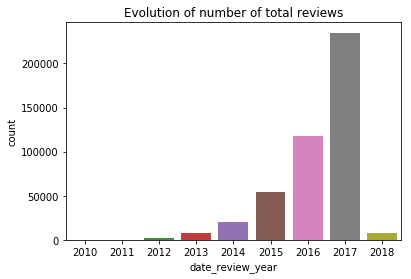

In [7]:
sns.countplot(airbnb.date_review_year)
plt.title("Evolution of number of total reviews")

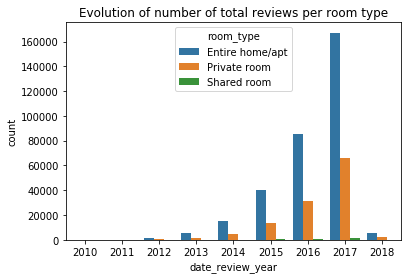

In [8]:
sns.countplot(x="date_review_year",hue="room_type",data=airbnb)
plt.title("Evolution of number of total reviews per room type")

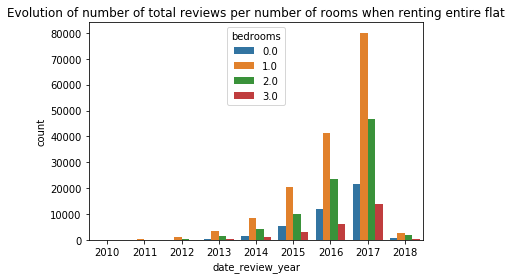

In [9]:
sns.countplot(x="date_review_year",hue="bedrooms",data=airbnb[(airbnb['room_type']=='Entire home/apt') & \
                                                              (airbnb['bedrooms']<4)])
plt.title("Evolution of number of total reviews per number of rooms when renting entire flat")

In [10]:
print("private room bedrooms: ",airbnb[airbnb['room_type']=='Private room']['bedrooms'].unique(),
      "entire appartment bedrooms",airbnb[airbnb['room_type']=='Entire home/apt']['bedrooms'].unique(),
      "shared room bedrooms",airbnb[airbnb['room_type']=='Shared room']['bedrooms'].unique())

private room bedrooms:  [ 1.  3.  4.  2.  6.  8. 10.  0. nan] entire appartment bedrooms [ 0.  4.  2.  1.  3.  5. nan  8.  6.  7. 10.] shared room bedrooms [1.]


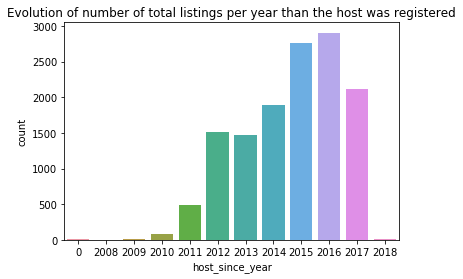

In [11]:
# number of listings per year that its host was registered
sns.countplot(n_listings.host_since_year)
plt.title("Evolution of number of total listings per year than the host was registered")

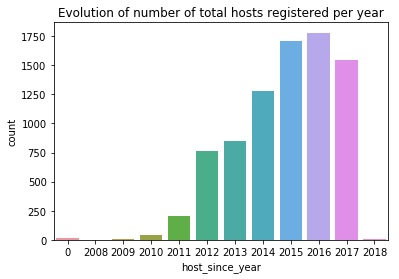

In [12]:
# number of host registered per year
sns.countplot(n_hosts.host_since_year)
plt.title("Evolution of number of total hosts registered per year")

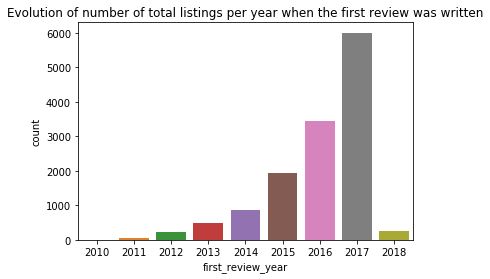

In [13]:
# number of listings per year that the listing was registered
sns.countplot(n_listings.first_review_year)
plt.title("Evolution of number of total listings per year when the first review was written")

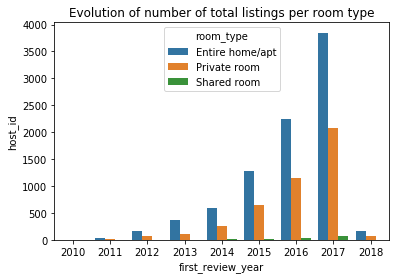

In [14]:
sns.barplot(x="first_review_year", y="host_id", hue="room_type", data=n_listings_room_type)
plt.title("Evolution of number of total listings per room type")

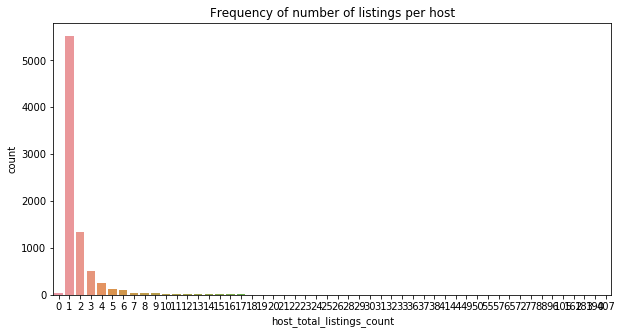

In [15]:
# explorar el aumento de host de los dos tipos
plt.figure(figsize=(10, 5))
sns.countplot(airbnb.ix[:,['host_id','host_total_listings_count']].groupby(['host_id']).first()['host_total_listings_count'].fillna(0).astype(int))
plt.title("Frequency of number of listings per host")

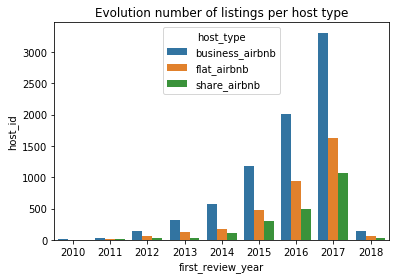

In [16]:
sns.barplot(x='first_review_year', y='host_id',hue='host_type',data=n_list_type_evol_)
plt.title("Evolution number of listings per host type")

In [19]:
#sns.barplot(x='date_review_year', y='listing_id',hue='host_type',data=n_revs_type_evol_)
#plt.title("Evolution number of reviews per host type")

In [22]:
n_list_type_evol_

,first_review_year,host_type,host_id,host_total_listings_count,room_type
0,2010,business_airbnb,7,7,7
1,2010,flat_airbnb,2,2,2
2,2011,business_airbnb,30,30,30
3,2011,flat_airbnb,8,8,8
4,2011,share_airbnb,7,7,7
5,2012,business_airbnb,144,144,144
6,2012,flat_airbnb,62,62,62
7,2012,share_airbnb,35,34,35
8,2013,business_airbnb,315,315,315
9,2013,flat_airbnb,126,126,126


### Rental and Sale prices per m2 evolution over time per district

In [3]:
sale = pd.read_csv('./data/sale_price_m2_districts.csv')
rent = pd.read_csv('./data/rent_price_m2_districts.csv')
link_location_price_data = "https://www.idealista.com/informes-precio-vivienda"

# drop vicalvaro since rental data is missing for 2016 and 2017
sale = sale[sale['district'] != 'vicálvaro']
rent = rent[rent['district'] != 'vicálvaro']
rent = rent[rent['district'] != '23 madrid']

sale['price_m2'] = sale['price_m2'].str.split(' ').apply(lambda x: ''.join(x)).str.split('.').apply(lambda x: ''.join(x)).astype(int)
rent['price_m2'] = rent['price_m2'].str.split(' ').apply(lambda x: ''.join(x).replace(',','.')).astype(float)

In [4]:
district_dict = {'arganzuela': 'Arganzuela',
 'barajas': 'Barajas',
 'carabanchel': 'Carabanchel',
 'centro': 'Centro',
 'chamartín': 'Chamartín',
 'chamberí': 'Chamberí',
 'ciudad lineal': 'Ciudad Lineal',
 'fuencarral': 'Fuencarral - El Pardo',
 'hortaleza': 'Hortaleza',
 'latina': 'Latina',
 'moncloa': 'Moncloa - Aravaca',
 'moratalaz': 'Moratalaz',
 'puente de vallecas': 'Puente de Vallecas',
 'retiro': 'Retiro',
 'salamanca': 'Salamanca',
 'san blas': 'San Blas - Canillejas',
 'tetuán': 'Tetuán',
 'usera': 'Usera',
 'villa de vallecas': 'Villa de Vallecas',
 'villaverde': 'Villaverde',
 'madrid': 'madrid'}

#sale['district'] = sale['district'].apply(lambda x: district_dict[x])
#rent['district'] = rent['district'].apply(lambda x: district_dict[x])

#### 2.1. Calculate ratios

In [5]:
def calculate_ratio_reference_idealista(data):
    ref_values = data.sort_values(by=['year']).groupby(['district']).first().reset_index().rename(columns={'price_m2':'price_m2_ref'})
    ref_values = ref_values.loc[:,['district','price_m2_ref']]
    data_ = data.merge(ref_values, left_on='district', right_on='district')
    data_['ratio_reference'] = data_['price_m2'] / data_['price_m2_ref']
    return data_

###### Evolution of sales prices per m2 by district since 2007

In [6]:
sale_ = calculate_ratio_reference_idealista(sale)

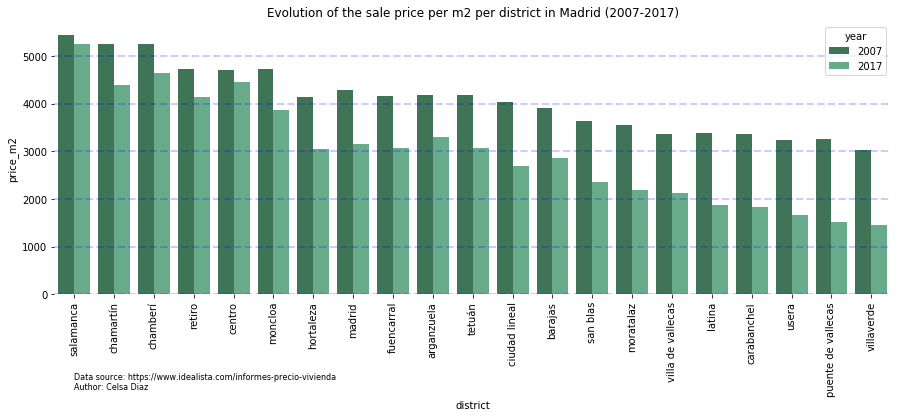

In [7]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='price_m2',data=sale_[sale_['year'].isin([2007,2017])],hue='year',
            order=['salamanca','chamartín','chamberí','retiro',
                                                       'centro','moncloa','hortaleza','madrid',
                                                       'fuencarral','arganzuela','tetuán','ciudad lineal',
                                                       'barajas','san blas','moratalaz',
                                                       'villa de vallecas','latina','carabanchel',
                                                       'usera','puente de vallecas','villaverde'],
           palette="BuGn_d")
ax.set_title("Evolution of the sale price per m2 per district in Madrid (2007-2017)")
plt.text(0, -2000, "Data source: "+link_location_price_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
_ = plt.xticks(rotation='vertical')

In [8]:
sale_kpi = sale_.loc[:,['year','district','ratio_reference']].pivot(index='year', 
                                                                     columns='district', 
                                                                     values='ratio_reference').drop(['madrid'],axis=1)
districts = sale_kpi.columns.tolist()
dates = sale_kpi.index.unique().tolist()
y_min = sale_['ratio_reference'].min()
y_max = sale_['ratio_reference'].max()
y_interval = 0.11
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = 2017
legend_y_pos = [0.78685782556750294, 0.734375, 0.54188948306595364, 0.94607218683651806, 0.83441187666539784, 0.88419047619047619, 0.66799007444168734, 0.73690533397405089, 0.73571256329877022, 0.5557527358769595, 0.81845049609457465, 0.61748173130972461, 0.46693325130729008, 0.87595258255715491, 0.96632934682612692, 0.65205403915081339, 0.73306297709923662, 0.51347166305357694, 0.6314379279547484, 0.47612775765558119]
link_source_hight = 0.1
title = "Evolution of the sale price per m2 with respect to 2007 prices per district in Madrid (2007-2017)"

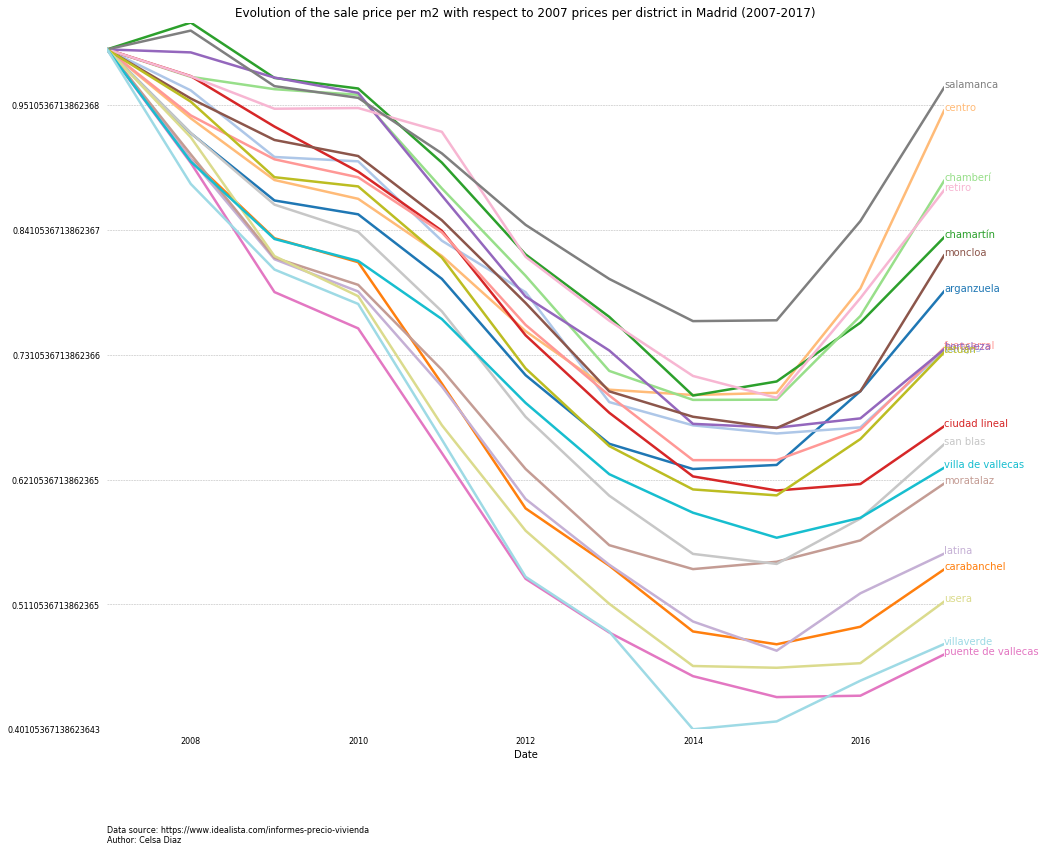

In [11]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               sale_kpi, title, link_location_price_data, link_source_hight)

###### Evolution of rental prices per m2 by district since 2007

In [12]:
rent_ = calculate_ratio_reference_idealista(rent)

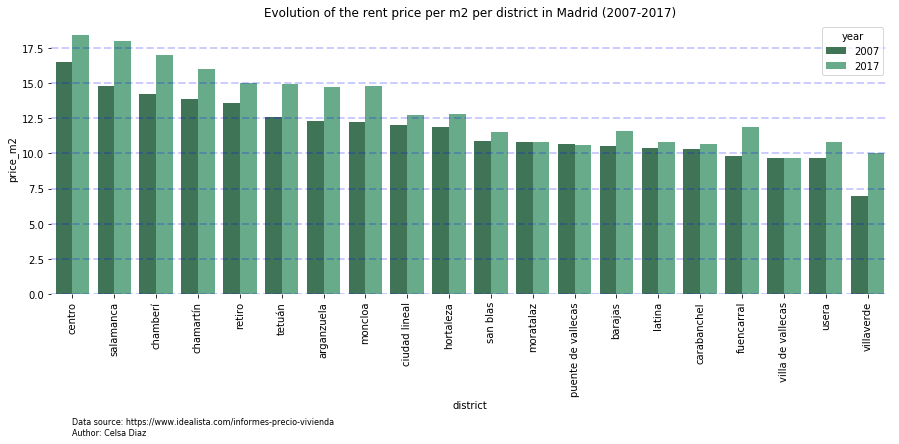

In [13]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='price_m2',data=rent_[rent_['year'].isin([2007,2017])],hue='year',
            order=['centro','salamanca','chamberí','chamartín','retiro','tetuán','arganzuela',
                                                       'moncloa','ciudad lineal','hortaleza',
                                                       'san blas','moratalaz','puente de vallecas',
                                                       'barajas','latina','carabanchel','fuencarral',
                                                       'villa de vallecas',
                                                       'usera','villaverde'],
           palette="BuGn_d")
ax.set_title("Evolution of the rent price per m2 per district in Madrid (2007-2017)")
plt.text(0, -10, "Data source: "+link_location_price_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
_ = plt.xticks(rotation='vertical')

In [14]:
rent_kpi = rent_.loc[:,['year','district','ratio_reference']].pivot(index='year', 
                                                                     columns='district', 
                                                                     values='ratio_reference').drop(['madrid'],axis=1)
districts = rent_kpi.columns.tolist()
dates = rent_kpi.index.unique().tolist()
y_min = rent_['ratio_reference'].min()
y_max = rent_['ratio_reference'].max()
y_interval = 0.1
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = 2017
legend_y_pos = [1.1951219512195121, 1.1047619047619048, 1.0388349514563104, 1.115151515151515, 1.1510791366906474, 1.1971830985915493, 1.0583333333333333, 1.2142857142857142, 1.0756302521008403, 1.0384615384615385, 1.2131147540983609, 1.0, 0.99065420560747663, 1.1029411764705883, 1.2162162162162162, 1.0550458715596329, 1.1825396825396826, 1.1134020618556704, 1.0, 1.4285714285714286]
link_source_hight = 0.1
title = "Evolution of the rent price per m2 with respect to 2007 prices per district in Madrid (2007-2017)"

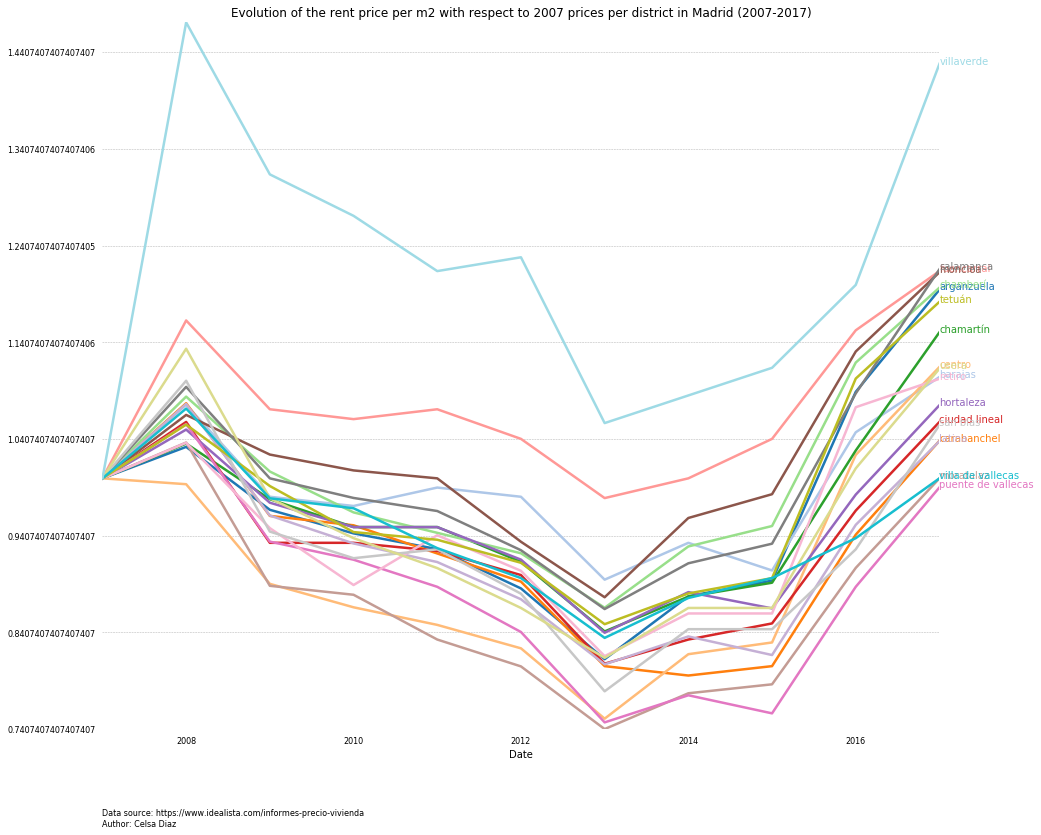

In [15]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               rent_kpi, title, link_location_price_data, link_source_hight)

In [58]:
rent_.to_csv('./data/rent_price_m2_districts_ratio.csv', index=False, encoding='utf-8')
sale_.to_csv('./data/sale_price_m2_districts_ratio.csv', index=False, encoding='utf-8')

###### Conclusions:
* There was a clear buble generated by having the lowest price of flats in Villaverde (a traditionally worker district) at 2014. Likely, this fenomena increased the number of sales and created a flow of poorer citizens to the district looking for afordable flats.
* Villaverde is the district with highest rate of listings per host with Centro. This is specially surprising since it is not one of the gentrified districts of Madrid. I suggest that it became the perfect place for speculation in crisis time where many families from low and middle class needed to find cheeper alternatives. Airbnb, despite of the original idea, became a great solution for survival in this district seems like.
* The price of m2 did not recover from the crisis yet, the main dicrease was in worker districts. These districts were more affected by the increase of unemployment and the fact is that many families had to sell their flats quickly much cheaper than the bought them. The need to sell may have had an effect on the decrease of the prices.
* On the other hand, the economical crisis generated a buble in the rental business, mainly in one of the humblest districts, Villaverde and the traditionally gentrified areas.
* Regarding the acceptance of Airbnb, we can see from the evolution of the number of listings over these years that gentrified districts quickly started to used whereas other districts in the suburbs took longer and only those with more market interest develop stronger. Two examples are Villaverde and Barajas, the district closed to the airport.